#Exploring a single Poisson Change Point detection
Scott Hendrickson (@drskippy)

2014-Nov-27

In [5]:
%pylab inline
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Start with simulated statistics.  Poisson model:

$$p(x) = \frac{{e^{ - \lambda } \lambda ^x }}{{x!}}$$

The model is poisson-distributed counts of events per bucket before and after a discontinuous mean change ($\lambda_{before} \rightarrow \lambda_{after}$).

The parameter abRatio is the simple ration of the paramters,

$$\text{abRatio} = \frac{\lambda_{after}}{\lambda_{below}}$$

Start with a simple exploration where we model a single change point over and over to see how the distribution before and after the change can be compared from a statistical distribution point of view. We will look at 2,000 change point simulations and compare before and after distributions for a range starting value of $\lambda_i = 4$ and a range of final $4 \le \lambda_f \le 20$.

In [6]:
sample_size = 2000
starting_lambda = 4.
lambda_range = 16

Generate a range of changes to explore with the following code.

In [7]:
df = pd.DataFrame(columns=('count_diff', 'count', 'abRatio')
                  , index=range(sample_size*lambda_range))
index = 0
for i in range(lambda_range):
    a = starting_lambda + i
    for x,y in zip(np.random.poisson(a, sample_size) - 
                    np.random.poisson(starting_lambda, sample_size)
               , np.concatenate((np.random.poisson(starting_lambda, int(sample_size/2))
                    , np.random.poisson(a, int(sample_size/2))), axis = 0)):
        df.loc[index] = [x, y, float(a)/starting_lambda]
        index += 1
#df.head()

In terms of abRatio, the separation of the before and after peaks of the count distribution give us an intuitive sense of how easy it will be to measure the differene between the average before and after the change.  The lareger the change, the more distance between the peaks of the before and after distributions. For small values of abRatio, the overall distribution of points before and after the change point is spread slightly. For larger values of abRatio, the peaks become cleanly distinguished.

The plots below show the progression of abRatio's over the the range described above.

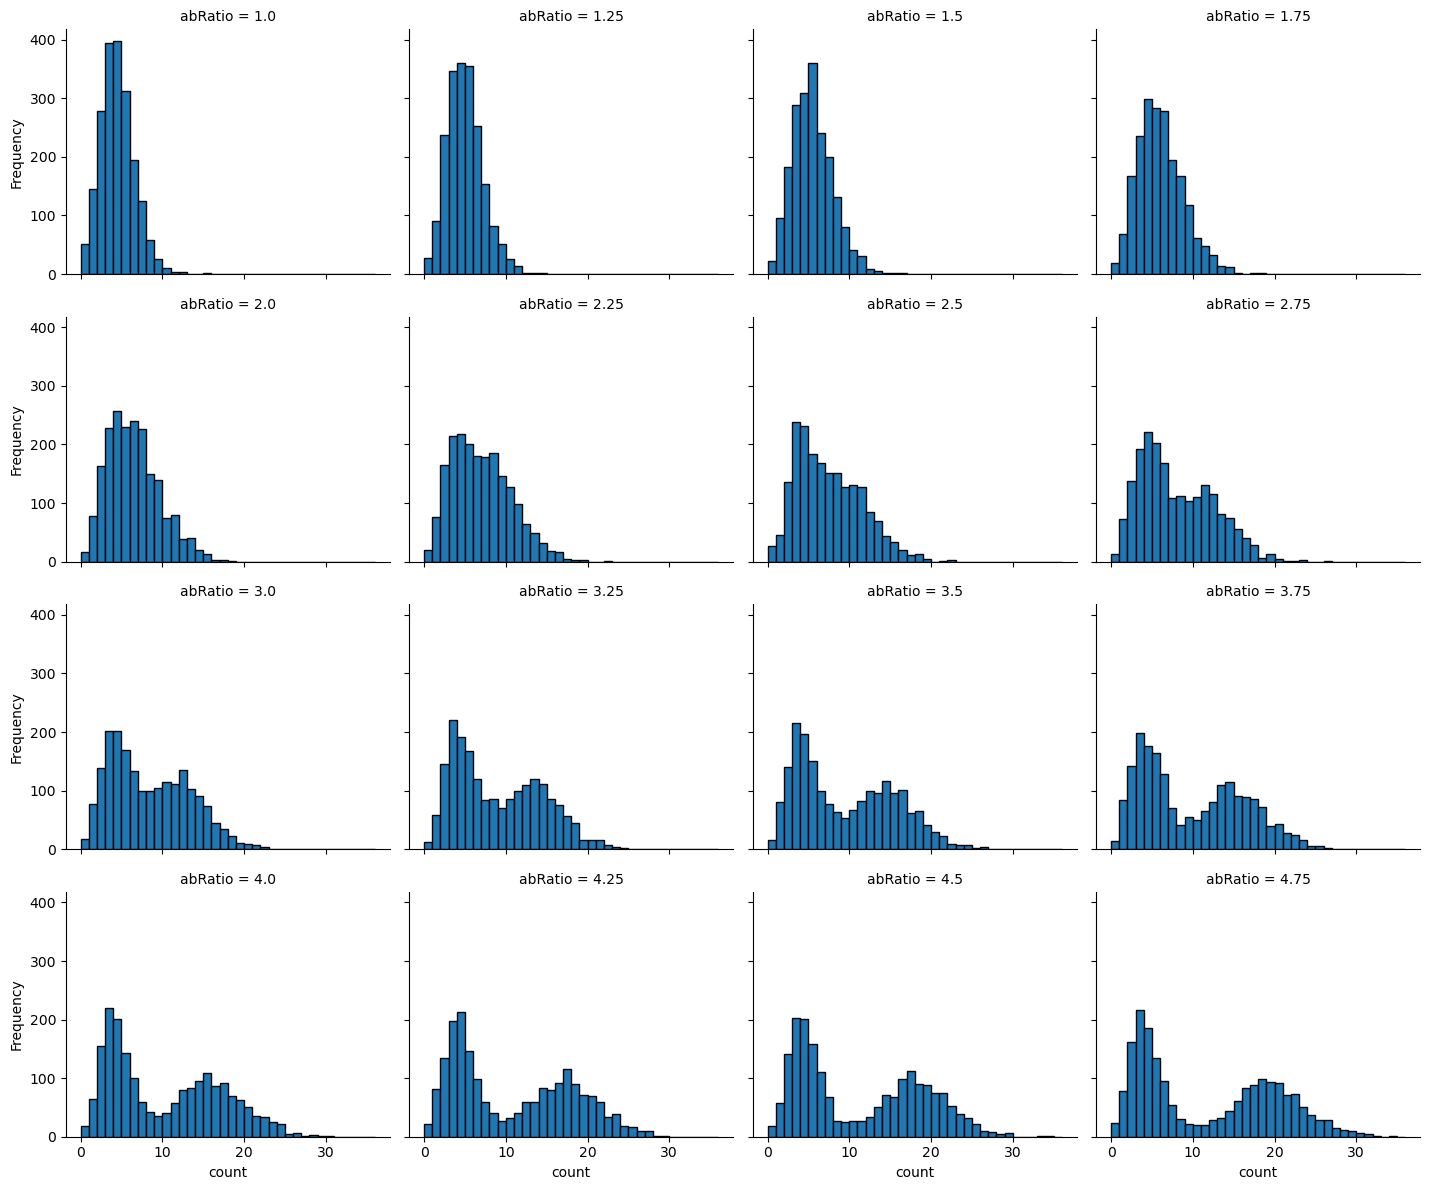

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create faceted histogram using seaborn
g = sns.FacetGrid(df, col='abRatio', col_wrap=4, height=3, aspect=1.2)
g.map(plt.hist, 'count', bins=range(int(df['count'].min()), int(df['count'].max()) + 2), edgecolor='black')
g.set_axis_labels('count', 'Frequency')
g.set_titles('abRatio = {col_name}')
plt.tight_layout()
plt.show()

As the ratio of the change increases, the mid-section of the tail gets fatter until the peaks of the individual distributions become increasingly distinct.

What does the distribution of the ${difference}$ of the before and after time series?

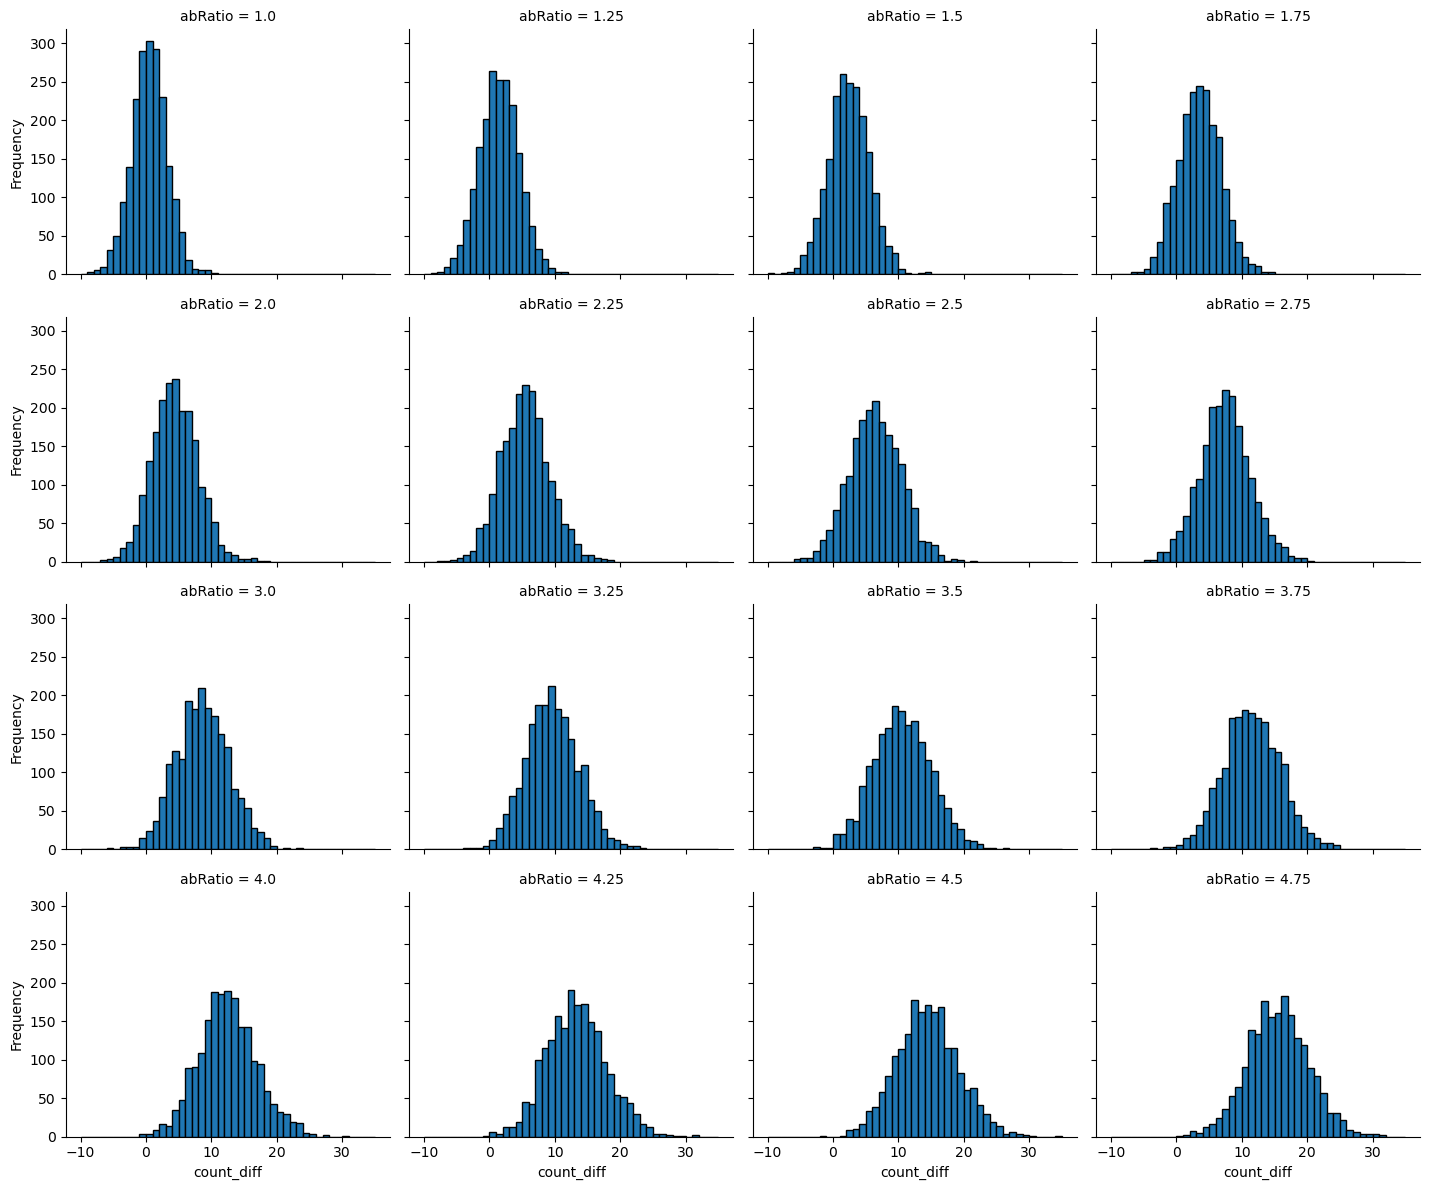

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create faceted histogram for count_diff using seaborn
g = sns.FacetGrid(df, col='abRatio', col_wrap=4, height=3, aspect=1.2)
g.map(plt.hist, 'count_diff', bins=range(int(df['count_diff'].min()), int(df['count_diff'].max()) + 2), edgecolor='black')
g.set_axis_labels('count_diff', 'Frequency')
g.set_titles('abRatio = {col_name}')
plt.tight_layout()
plt.show()

In general, we a looking for signal, i.e., the difference is greater than zero for an increase, or less than zero for a decrease. 

To illustrate an intuitive approach to signal detection, it may be interesting to look at the fraction of the output where the difference is above zero.  Below, we create a table of outputs for the ratios. (The table function has funky output column labels!) The second column shows the fraction of total instances in which the difference of the averages is greater than zero given a real change in $\lambda$.  The fraction of times the measured is greater than zero when there is a real change in $\lambda$ hits 99% when $abRatio>3.5$.

         abRatio
abRatio         
1.00      0.4255
1.25      0.5585
1.50      0.6780
1.75      0.7850
2.00      0.8400
2.25      0.8935
2.50      0.9190
2.75      0.9515
3.00      0.9760
3.25      0.9900
3.50      0.9875
3.75      0.9940
4.00      0.9965
4.25      0.9965
4.50      0.9995
4.75      0.9995


<Axes: xlabel='abRatio'>

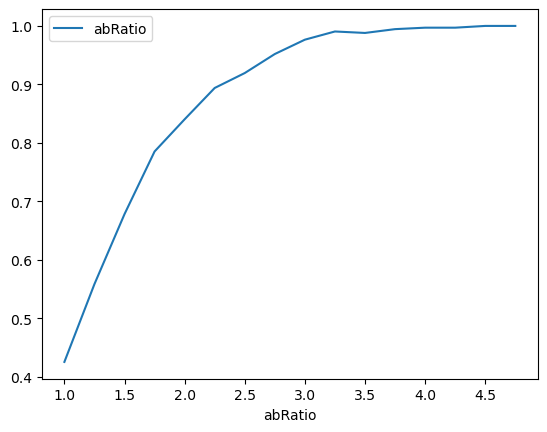

In [10]:
output = pd.DataFrame(df[df.count_diff>0].groupby(
        df.abRatio).count()['abRatio']/sample_size)
print(output)
output.plot()

Hardly intuitively, the distribution of the difference of two poisson distributions is a Skellam distribution! Our simple simulations matches the Skellam prediction closly as shown in the graphs below.

       Skellam Simulation
1.00  0.428284     0.4255
1.25  0.564928     0.5585
1.50   0.68204      0.678
1.75  0.775649      0.785
2.00  0.846487       0.84
2.25   0.89776     0.8935
2.50  0.933522      0.919
2.75  0.957692     0.9515
3.00  0.973589      0.976
3.25  0.983798       0.99
3.50  0.990217     0.9875
3.75  0.994179      0.994
4.00  0.996582     0.9965
4.25  0.998017     0.9965
4.50  0.998863     0.9995
4.75  0.999355     0.9995


<Axes: >

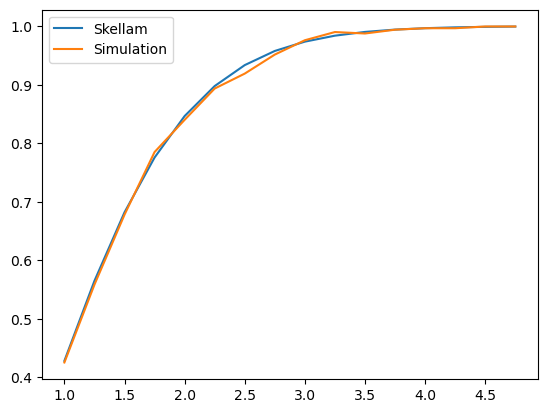

In [11]:
from scipy.stats import skellam
idx = [float(starting_lambda+i)/starting_lambda for i in range(lambda_range)]
sk = pd.DataFrame(columns=('Skellam','Simulation'), index = idx)
for i,k in enumerate(idx):
    sk.loc[k] = [skellam.cdf(-1, starting_lambda
                             , starting_lambda+i), output.loc[k]["abRatio"]]
print(sk)
sk.plot()

What is that?

##It is easy to build a very naive likelihood change point model

This is helpful to see how this sort of model might work. Don't use this simple model for a real detection algorithm!

The model comes from calculating $P(\lambda_0 \rightarrow \lambda_f) = \Pi_i P(x_i|\lambda_0) \Pi_j P(x_j|\lambda_f)$ for the i points before and the j points after the change point. Working with log likelihood turns these products of probabilities into sums.  Working out the algebra gives the function below.

In [12]:
import math
def log_like(vec, n):
    m = float(len(vec) - n)
    sn = sum(vec[:n])
    sm = sum(vec[n:])
    n = float(n)
    pvec = [x*y for x,y in zip(vec,map(math.log, vec))]
    return -sum(pvec) + sn * math.log(sn/n) + sm * math.log(sm/m)


Let's try an example: Make a time series with a some $\lambda$ changes.

In [13]:
sample_size = 40
b = 10
a = 30
data = list(
            np.concatenate(
                           (np.random.poisson(b, sample_size)
                          , np.random.poisson(a, sample_size)
                          , np.random.poisson(b, sample_size)
                          , np.random.poisson(2*a, sample_size)
                          )
                , axis = 0))

Calculate our simple signal on the time series we created.

In [14]:
df1 = pd.DataFrame(columns=["time","data","signal"]
                   , index=range(len(data)))
n_backward = 8
n_forward = 2
for i in range(0, len(data)):
    if i < n_backward + n_forward:
        df1.loc[i] = [i, data[i], 0.0]
    else:
        df1.loc[i] = [i, data[i], log_like(
            data[i-n_backward-n_forward:i], n_backward)]

Plot the time series and signal.  With some care and refinement, it seems clear this idea can be used to detect mean shifts. 

To use a real Python package, go here http://nbviewer.ipython.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb

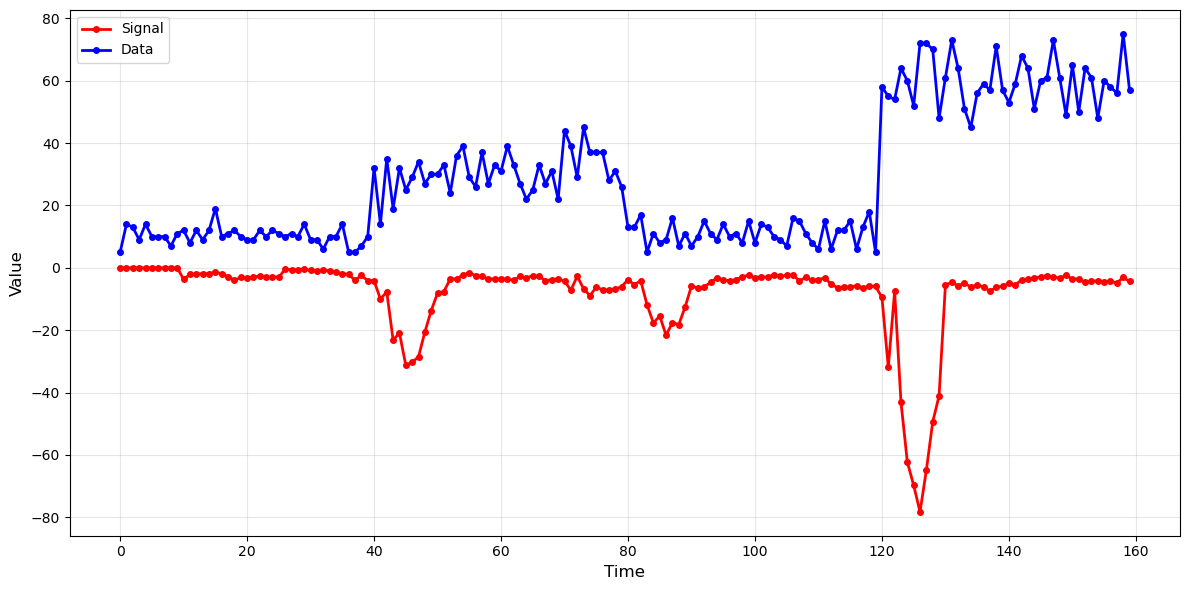

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Plot signal in red
ax.plot(df1['time'], df1['signal'], color='red', marker='o', linestyle='-', linewidth=2, markersize=4, label='Signal')

# Plot data in blue
ax.plot(df1['time'], df1['data'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=4, label='Data')

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()